In [32]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [33]:
data= pd.read_csv('/content/IDR=X.csv')
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-03-18,14251.0,14283.000000,14204.0,14251.0,14251.0,0.0
1,2019-03-19,14246.0,14252.000000,14163.0,14251.0,14251.0,0.0
2,2019-03-20,14224.0,14233.299805,14159.0,14223.0,14223.0,0.0
3,2019-03-21,14115.5,14159.000000,14055.0,14055.0,14055.0,0.0
4,2019-03-22,14152.5,14279.000000,14120.0,14133.0,14133.0,0.0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1306 non-null   object 
 1   Open       1305 non-null   float64
 2   High       1305 non-null   float64
 3   Low        1305 non-null   float64
 4   Close      1305 non-null   float64
 5   Adj Close  1305 non-null   float64
 6   Volume     1305 non-null   float64
dtypes: float64(6), object(1)
memory usage: 71.5+ KB


In [35]:
data.isnull().sum()

Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [36]:
data.dropna(inplace=True)

In [37]:
data.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [38]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1305.000000,1305.000000,1305.000000,1305.000000,1305.000000,1305.0
mean,14691.414431,14744.803468,14596.635502,14676.134620,14676.134620,0.0
std,580.110043,590.574527,576.296909,580.473058,580.473058,0.0
min,13452.924805,13657.900391,13082.000000,13213.240234,13213.240234,0.0
25%,14248.000000,14283.000000,14157.900391,14237.000000,14237.000000,0.0
50%,14527.730469,14575.599609,14426.900391,14520.799805,14520.799805,0.0
75%,15078.799805,15158.299805,14987.000000,15077.000000,15077.000000,0.0
max,17144.000000,17178.000000,16440.923828,16504.800781,16504.800781,0.0


In [39]:
jumlah_sampel = data.shape[0]

print("Jumlah sampel dalam dataset:", jumlah_sampel)

Jumlah sampel dalam dataset: 1305


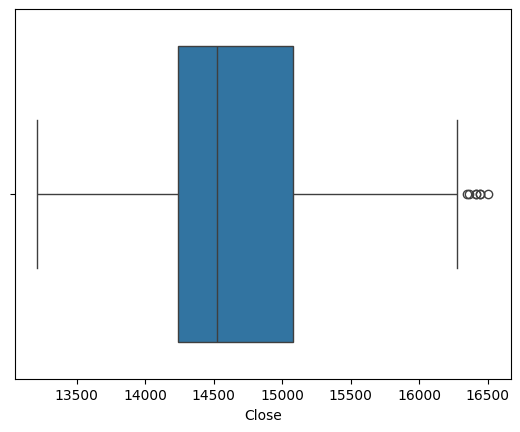

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualisasi boxplot untuk kolom tertentu
sns.boxplot(x=data['Close'])
plt.show()

In [41]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR=Q3-Q1
data=data[~((data<(Q1-1.5*IQR))|(data>(Q3+1.5*IQR))).any(axis=1)]

# Cek ukuran dataset setelah kita drop outliers
data.shape

<ipython-input-41-2df2d5d7a7fb>:1: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q1 = data.quantile(0.25)
<ipython-input-41-2df2d5d7a7fb>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  Q3 = data.quantile(0.75)
<ipython-input-41-2df2d5d7a7fb>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  data=data[~((data<(Q1-1.5*IQR))|(data>(Q3+1.5*IQR))).any(axis=1)]


(1295, 7)

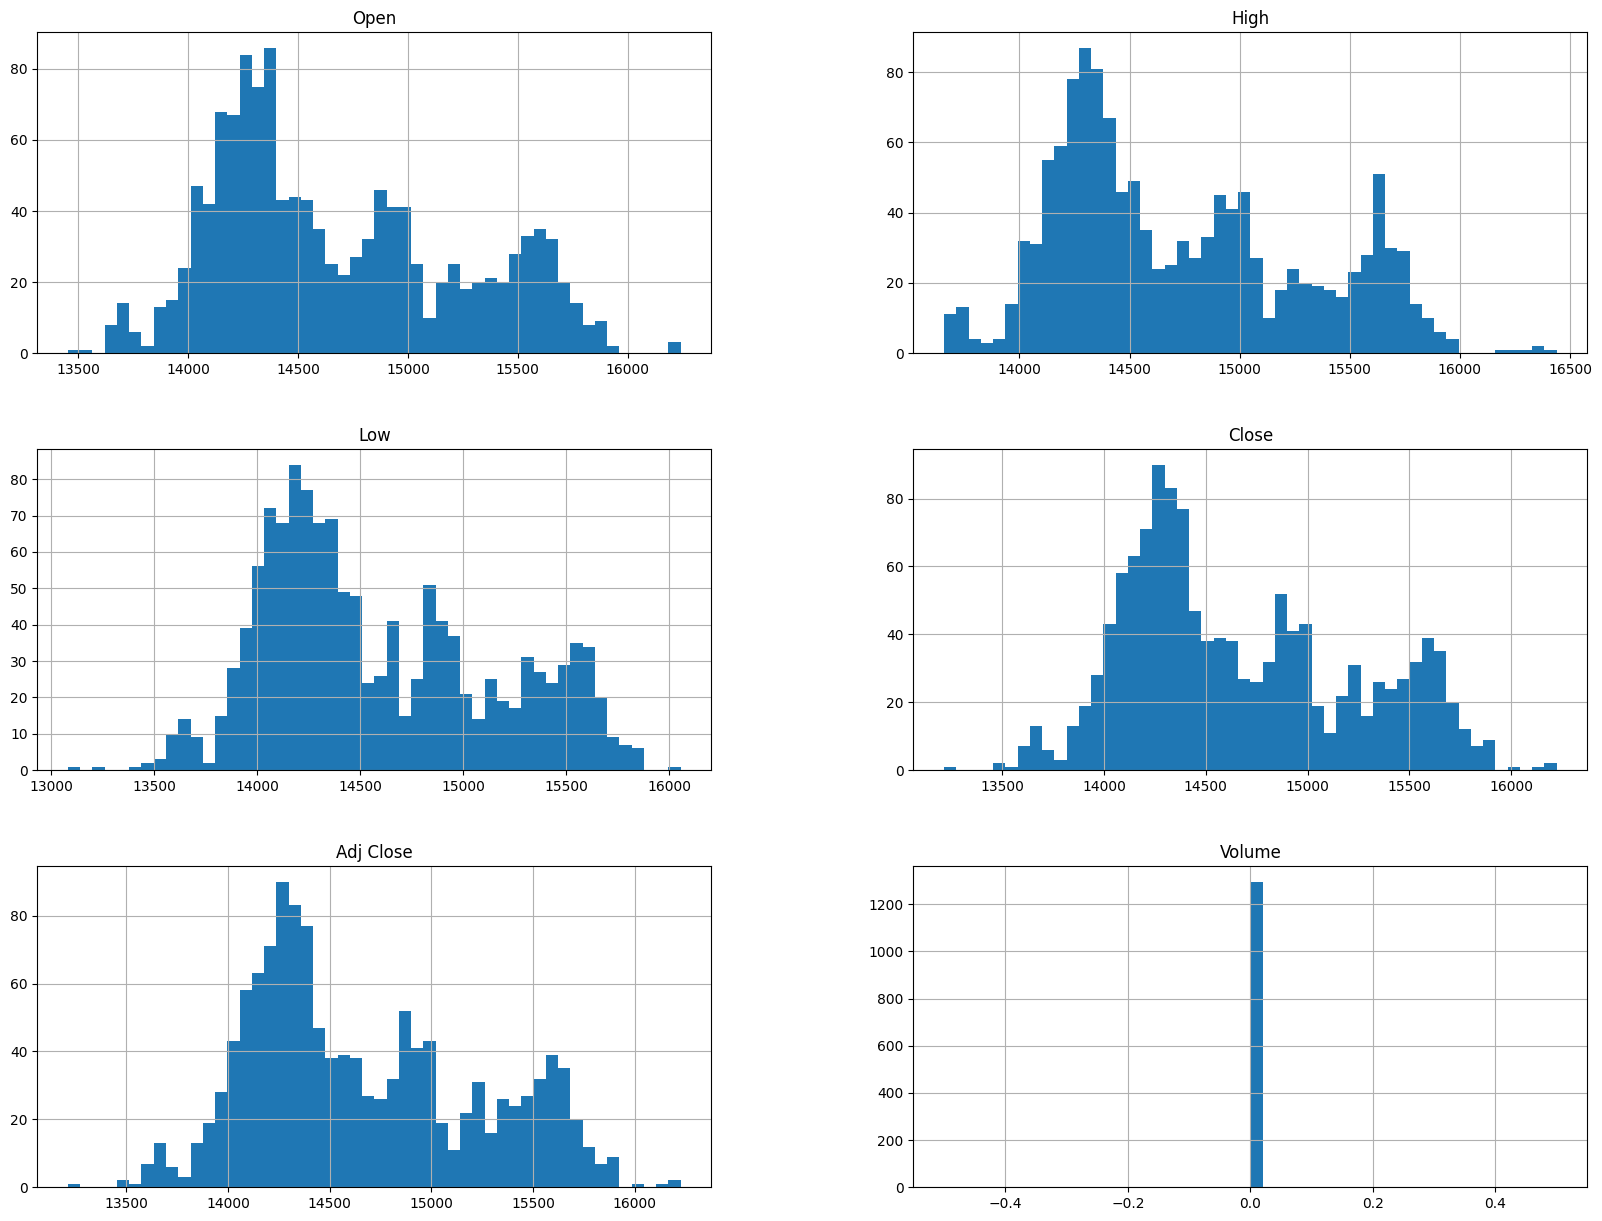

In [42]:
data.hist(bins=50, figsize=(20,15))
plt.show()

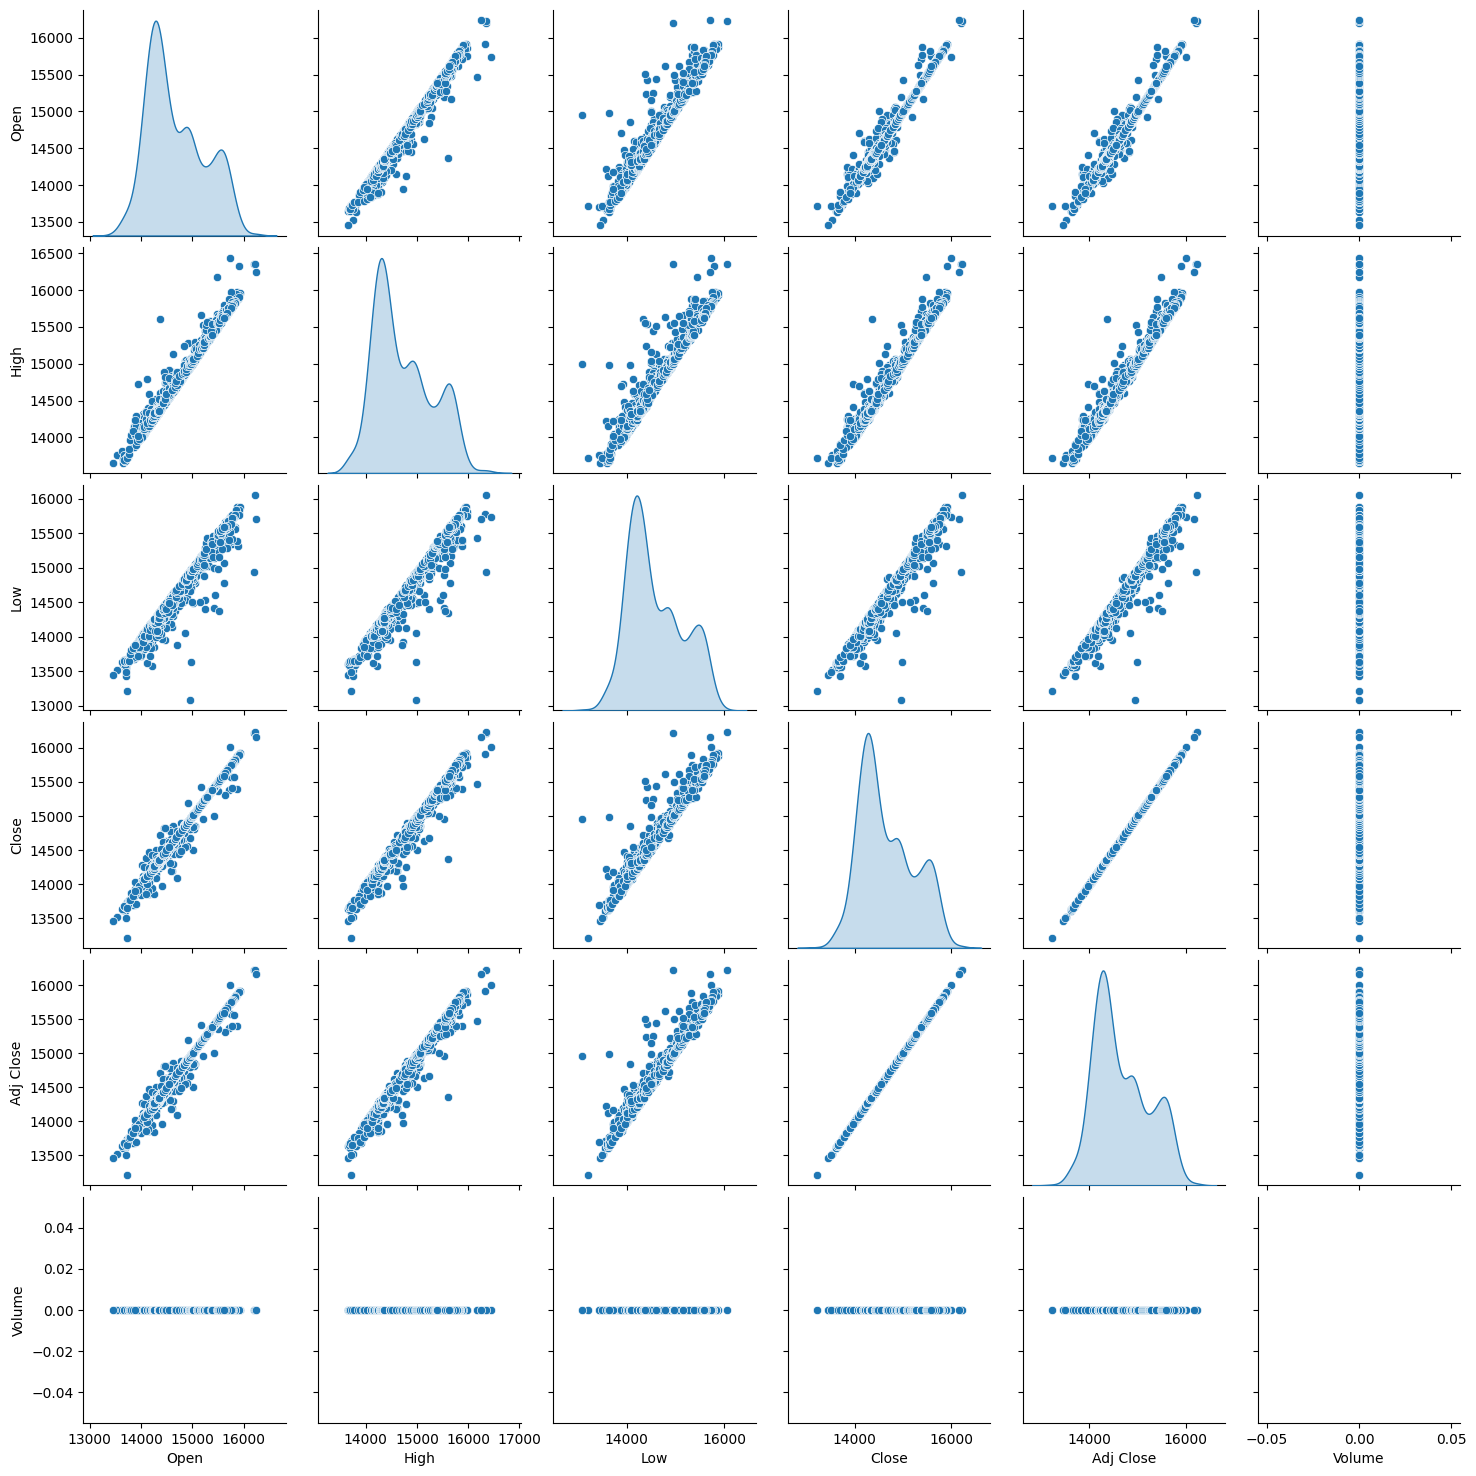

In [43]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(data, diag_kind = 'kde')

<ipython-input-44-5ff959f2f38a>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr().round(2)


Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

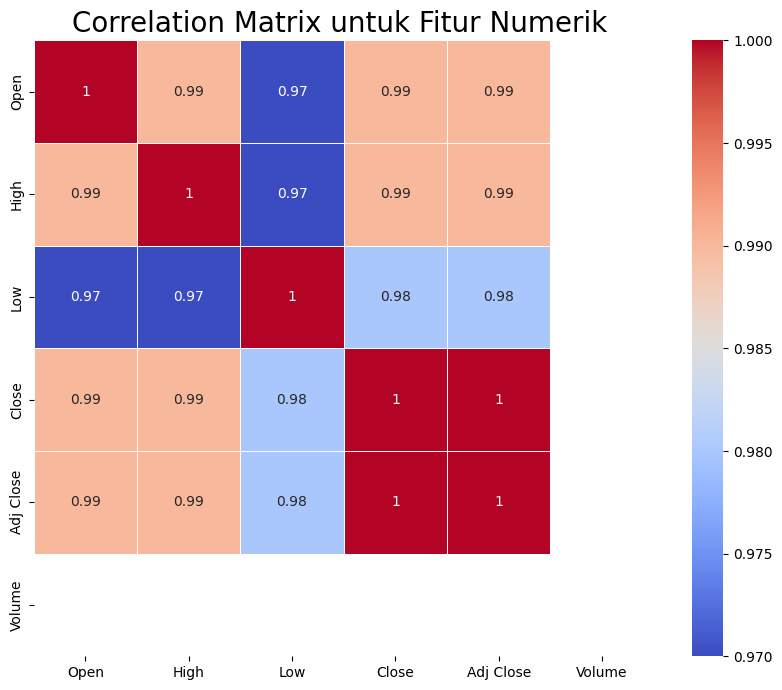

In [44]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr().round(2)

# Untuk menge-print nilai di dalam kotak, gunakan parameter anot=True
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

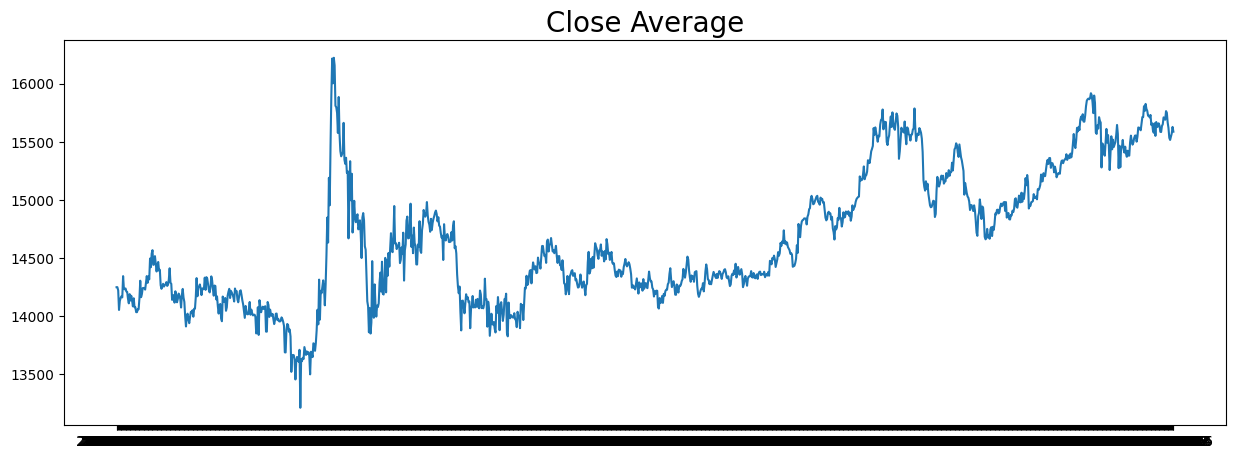

In [45]:
dates = data['Date'].values
close  = data['Close'].values


plt.figure(figsize=(15,5))
plt.plot(dates, close)
plt.title('Close Average',
          fontsize=20);

In [46]:

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close']])

In [47]:
scaled_data

array([[0.34456924],
       [0.34456924],
       [0.33527235],
       ...,
       [0.7838473 ],
       [0.80244108],
       [0.78882778]])

In [48]:
# Split data menjadi training dan validation set
train_data, val_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)


In [49]:
def create_dataset(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

In [50]:
time_steps = 30

X_train, y_train = create_dataset(train_data, time_steps)
X_val, y_val = create_dataset(val_data, time_steps)

model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])


In [51]:
from tensorflow.keras.callbacks import EarlyStopping

optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Melatih model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
32/32 [==============================] - 7s 78ms/step - loss: 0.0385 - mae: 0.2248 - val_loss: 0.0288 - val_mae: 0.2186
Epoch 2/100
32/32 [==============================] - 1s 36ms/step - loss: 0.0114 - mae: 0.1167 - val_loss: 0.0317 - val_mae: 0.2341
Epoch 3/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0098 - mae: 0.1089 - val_loss: 0.0279 - val_mae: 0.2204
Epoch 4/100
32/32 [==============================] - 1s 34ms/step - loss: 0.0083 - mae: 0.0983 - val_loss: 0.0217 - val_mae: 0.1922
Epoch 5/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0069 - mae: 0.0878 - val_loss: 0.0157 - val_mae: 0.1618
Epoch 6/100
32/32 [==============================] - 1s 33ms/step - loss: 0.0056 - mae: 0.0801 - val_loss: 0.0107 - val_mae: 0.1322
Epoch 7/100
32/32 [==============================] - 1s 35ms/step - loss: 0.0044 - mae: 0.0676 - val_loss: 0.0071 - val_mae: 0.1071
Epoch 8/100
32/32 [==============================] - 1s 38ms/step - loss: 0.

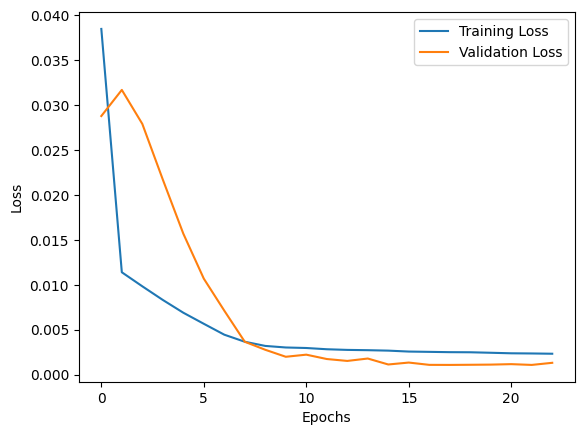

In [52]:
# Plot loss dan akurasi
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# Prediksi menggunakan model
predictions = model.predict(X_val)

# Menghitung MAE
mae = np.mean(np.abs(predictions - y_val))
print("Mean Absolute Error:", mae)

# Menghitung threshold untuk MAE < 10% skala data
threshold_mae = (scaled_data.max() - scaled_data.min()) * 10/100
print("Threshold MAE:", threshold_mae)

8/8 [==============================] - 1s 11ms/step
Mean Absolute Error: 0.036808406838954706
Threshold MAE: 0.1


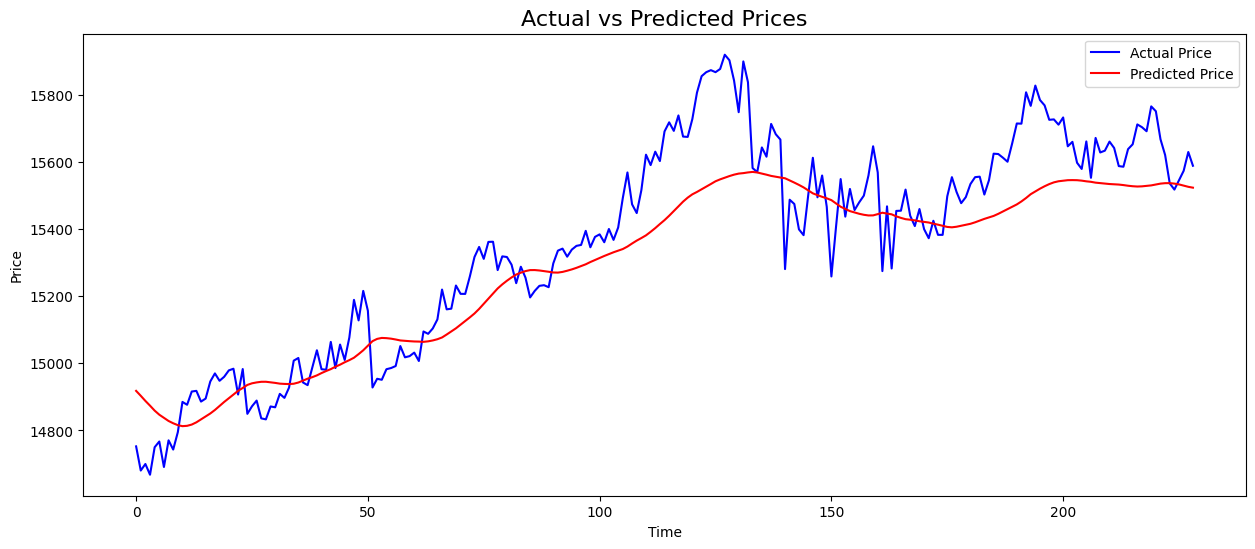

In [54]:
# Invers scaling untuk mendapatkan harga aktual dan prediksi yang sebenarnya
actual_prices = scaler.inverse_transform(y_val.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predictions)

# Plot harga aktual dan harga prediksi
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('Actual vs Predicted Prices', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [55]:
from datetime import datetime, timedelta

# Meminta pengguna untuk memasukkan tanggal
input_date = input("Masukkan tanggal (format: YYYY-MM-DD): ")

# Ubah input tanggal menjadi objek datetime
input_date = datetime.strptime(input_date, '%Y-%m-%d')

# Ambil data terakhir dalam dataset
last_date = datetime.strptime(data['Date'].iloc[-1], '%Y-%m-%d')

# Jika tanggal yang dimasukkan lebih besar dari tanggal terakhir dalam dataset, gunakan data terakhir yang tersedia
if input_date > last_date:
    print("Tanggal yang dimasukkan lebih besar dari tanggal terakhir dalam dataset.")
    input_date = last_date

# Ambil sejumlah data terakhir sebelum tanggal yang dimasukkan pengguna
input_index = data[data['Date'] == input_date.strftime('%Y-%m-%d')].index[0]
input_data = scaled_data[input_index - time_steps + 1:input_index + 1]

# Bentuk dataset untuk prediksi
X_prediction = np.array([input_data])

# Lakukan prediksi menggunakan model
predicted_price = model.predict(X_prediction)

# Ubah hasil prediksi ke dalam skala semula
predicted_price = scaler.inverse_transform(predicted_price)

# Tampilkan hasil prediksi
print("Prediksi harga untuk tanggal", input_date.strftime('%Y-%m-%d'), "adalah:", predicted_price[0][0])



Masukkan tanggal (format: YYYY-MM-DD): 2024-11-12
Tanggal yang dimasukkan lebih besar dari tanggal terakhir dalam dataset.
1/1 [==============================] - 1s 1s/step
Prediksi harga untuk tanggal 2024-03-16 adalah: 15435.854
